# Hierarchical Classification - Stage 2: Fine Pathology Training

This notebook trains **Stage 2 (Fine Classifiers)** of the hierarchical classification model.

## Prerequisites
- Run `03a_stage1_coarse_training.ipynb` first to train and save the coarse classifier

## Training Pipeline
- **Stage 1 (Previous Notebook)**: Pre-trained coarse classifier (anatomical regions)
- **Stage 2 (This Notebook)**: Load Stage 1 weights, train entire model **end-to-end**

## End-to-End Training (NO FREEZING)
Unlike traditional transfer learning where early layers are frozen, we train the entire model together. This allows the shared backbone to adapt its representations for the fine-grained pathology classification task.

## Fine Classifiers
- **Abdomen**: Organ classification
- **Chest**: Nodule and fracture classification
- **Brain**: Vessel classification

In [1]:
import sys
sys.path.insert(0, '..')

import os
import json
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from config import (
    DEVICE, DATA_CONFIG, MODEL_CONFIG, TRAINING_CONFIG,
    PATHS, set_seed, DEFAULT_MERGED_DATASETS
)
from utils.data_loader import create_hierarchical_dataset
from utils.hierarchical_model import HierarchicalClassificationModel

set_seed(42)
print(f"Device: {DEVICE}")

GPU detected: NVIDIA GeForce RTX 3060 Ti
GPU memory: 8.59 GB
Device: cuda


## 1. Load Stage 1 Configuration

In [2]:
# Load Stage 1 information
stage1_info_path = f"{PATHS['models']}/stage1_info_{MODEL_CONFIG['architecture']}.json"

if not os.path.exists(stage1_info_path):
    raise FileNotFoundError(
        f"Stage 1 info file not found at {stage1_info_path}. "
        "Please run 03a_stage1_coarse_training.ipynb first."
    )

with open(stage1_info_path, 'r') as f:
    stage1_info = json.load(f)

print("Stage 1 Information:")
print(f"  Model path: {stage1_info['model_path']}")
print(f"  Architecture: {stage1_info['architecture']}")
print(f"  Coarse Test Accuracy: {stage1_info['test_accuracy']:.4f}")
print(f"  Best Val Accuracy: {stage1_info['best_val_accuracy']:.4f}")

Stage 1 Information:
  Model path: c:\Users\BS-06\Desktop\HMIC\HierarchicalMIC\models/stage1_coarse_efficientnet3d_b0.pth
  Architecture: efficientnet3d_b0
  Coarse Test Accuracy: 0.8136
  Best Val Accuracy: 0.7981


## 2. Load Merged Dataset

In [3]:
# Load all 5 merged datasets
print(f"Loading datasets: {DEFAULT_MERGED_DATASETS}")

train_loader, val_loader, test_loader, dataset_info = create_hierarchical_dataset(
    datasets_to_include=DEFAULT_MERGED_DATASETS,
    batch_size=DATA_CONFIG['batch_size'],
    num_workers=DATA_CONFIG['num_workers']
)

print("\n" + "="*60)
print("MERGED DATASET INFO")
print("="*60)
print(f"Datasets: {dataset_info['datasets_included']}")
print(f"Train samples: {dataset_info['train_samples']:,}")
print(f"Val samples: {dataset_info['val_samples']:,}")
print(f"Test samples: {dataset_info['test_samples']:,}")
print(f"\nCoarse classes (regions): {dataset_info['num_coarse_classes']}")
print(f"Region mapping: {dataset_info['idx_to_region']}")
print(f"Fine classes: {dataset_info['num_fine_classes']}")

Loading datasets: ['organ', 'nodule', 'adrenal', 'fracture', 'vessel']
Using downloaded and verified file: C:\Users\BS-06\.medmnist\organmnist3d.npz
Using downloaded and verified file: C:\Users\BS-06\.medmnist\nodulemnist3d.npz
Using downloaded and verified file: C:\Users\BS-06\.medmnist\adrenalmnist3d.npz
Using downloaded and verified file: C:\Users\BS-06\.medmnist\fracturemnist3d.npz
Using downloaded and verified file: C:\Users\BS-06\.medmnist\vesselmnist3d.npz
Using downloaded and verified file: C:\Users\BS-06\.medmnist\organmnist3d.npz
Using downloaded and verified file: C:\Users\BS-06\.medmnist\nodulemnist3d.npz
Using downloaded and verified file: C:\Users\BS-06\.medmnist\adrenalmnist3d.npz
Using downloaded and verified file: C:\Users\BS-06\.medmnist\fracturemnist3d.npz
Using downloaded and verified file: C:\Users\BS-06\.medmnist\vesselmnist3d.npz
Using downloaded and verified file: C:\Users\BS-06\.medmnist\organmnist3d.npz
Using downloaded and verified file: C:\Users\BS-06\.medmn

In [4]:
# Configure region-specific classes
region_configs = dataset_info['region_num_classes']
region_idx_to_name = dataset_info['idx_to_region']

print("Region configurations:")
for region, num_classes in region_configs.items():
    print(f"  {region}: {num_classes} classes")

Region configurations:
  abdomen: 10 classes
  chest: 8 classes
  brain: 2 classes


## 3. Build and Load Hierarchical Model with Stage 1 Weights

In [5]:
# Create hierarchical model
model = HierarchicalClassificationModel(
    region_configs=region_configs,
    architecture=MODEL_CONFIG['architecture'],
    coarse_model_type=MODEL_CONFIG['coarse_architecture'],
    fine_model_type=MODEL_CONFIG['fine_architecture'],
    dropout_rate=MODEL_CONFIG['dropout_rate'],
    region_idx_to_name=region_idx_to_name,
    num_total_organs=dataset_info['num_fine_classes'],
    use_subtypes=False
).to(DEVICE)

# Load Stage 1 weights
stage1_path = stage1_info['model_path']
if not os.path.exists(stage1_path):
    raise FileNotFoundError(
        f"Stage 1 model not found at {stage1_path}. "
        "Please run 03a_stage1_coarse_training.ipynb first."
    )

model.load_state_dict(torch.load(stage1_path))
print(f"\nLoaded Stage 1 weights from: {stage1_path}")

C:\Users\BS-06\AppData\Local\Temp\ipykernel_9764\1499373810.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(stage1_path))



Loaded Stage 1 weights from: c:\Users\BS-06\Desktop\HMIC\HierarchicalMIC\models/stage1_coarse_efficientnet3d_b0.pth


In [6]:
# End-to-End Training: All parameters are trainable!
print("\nEnd-to-End Training Mode (NO FREEZING)")
print("Both Stage 1 (Coarse) and Stage 2 (Fine) classifiers will be trained together.")

# Count parameters - all should be trainable
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel configuration:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Coarse architecture: {MODEL_CONFIG['coarse_architecture']}")
print(f"  Fine architecture: {MODEL_CONFIG['fine_architecture']}")


End-to-End Training Mode (NO FREEZING)
Both Stage 1 (Coarse) and Stage 2 (Fine) classifiers will be trained together.

Model configuration:
  Total parameters: 4,851,479
  Trainable parameters: 4,851,479
  Coarse architecture: efficientnet3d_b0
  Fine architecture: efficientnet3d_b0


## 4. End-to-End Training: Coarse + Fine Classifiers

This stage trains the entire hierarchical model end-to-end. Both the coarse classifier (from Stage 1) and the fine classifiers are trained together, allowing the shared backbone to adapt for the fine-grained pathology task.

In [7]:
def train_stage2(model, train_loader, val_loader, device, epochs, lr, region_idx_to_name):
    """Train entire hierarchical model end-to-end (no freezing)."""
    
    criterion = nn.CrossEntropyLoss()
    
    # Optimize ALL model parameters (end-to-end training)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'coarse_train_acc': [],
        'coarse_val_acc': [],
        'region_train_acc': {name: [] for name in region_idx_to_name.values()},
        'region_val_acc': {name: [] for name in region_idx_to_name.values()}
    }
    
    best_val_acc = 0.0
    
    print("\n=== End-to-End Training: Coarse + Fine Classifiers ===")
    print("(All parameters are trainable)\n")
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        
        # Tracking for coarse accuracy
        coarse_correct = 0
        coarse_total = 0
        
        region_correct = {name: 0 for name in region_idx_to_name.values()}
        region_total = {name: 0 for name in region_idx_to_name.values()}
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
        for batch in pbar:
            if len(batch) == 4:
                imgs, coarse_labels, fine_labels, _ = batch
            else:
                imgs, coarse_labels, fine_labels = batch
            imgs = imgs.to(device, dtype=torch.float32)
            if imgs.max() > 1:
                imgs = imgs / 255.0
            coarse_labels = coarse_labels.long().to(device)
            fine_labels = fine_labels.long().to(device)
            
            optimizer.zero_grad()
            batch_loss = 0.0
            
            # Also train coarse classifier (end-to-end)
            coarse_logits = model.forward_coarse(imgs)
            coarse_loss = criterion(coarse_logits, coarse_labels)
            batch_loss = batch_loss + coarse_loss
            
            # Track coarse accuracy
            coarse_preds = coarse_logits.argmax(1)
            coarse_correct += (coarse_preds == coarse_labels).sum().item()
            coarse_total += imgs.size(0)
            
            # Train each region's fine classifier
            for region_idx, region_name in region_idx_to_name.items():
                mask = (coarse_labels == region_idx)
                if not mask.any():
                    continue
                
                region_imgs = imgs[mask]
                region_fine_labels = fine_labels[mask]
                
                fine_logits = model.forward_fine(region_imgs, region_name)
                loss = criterion(fine_logits, region_fine_labels)
                batch_loss = batch_loss + loss
                
                preds = fine_logits.argmax(1)
                region_correct[region_name] += (preds == region_fine_labels).sum().item()
                region_total[region_name] += region_imgs.size(0)
            
            if isinstance(batch_loss, float) and batch_loss == 0.0:
                continue
            
            batch_loss.backward()
            optimizer.step()
            train_loss += batch_loss.item()
        
        # Compute training metrics
        avg_train_loss = train_loss / len(train_loader)
        total_correct = sum(region_correct.values())
        total_samples = sum(region_total.values())
        train_acc = total_correct / total_samples if total_samples > 0 else 0
        coarse_train_acc = coarse_correct / coarse_total if coarse_total > 0 else 0
        
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        history['coarse_train_acc'].append(coarse_train_acc)
        
        for region_name in region_idx_to_name.values():
            if region_total[region_name] > 0:
                acc = region_correct[region_name] / region_total[region_name]
            else:
                acc = 0.0
            history['region_train_acc'][region_name].append(acc)
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_coarse_correct = 0
        val_coarse_total = 0
        val_region_correct = {name: 0 for name in region_idx_to_name.values()}
        val_region_total = {name: 0 for name in region_idx_to_name.values()}
        
        with torch.no_grad():
            for batch in val_loader:
                if len(batch) == 4:
                    imgs, coarse_labels, fine_labels, _ = batch
                else:
                    imgs, coarse_labels, fine_labels = batch
                imgs = imgs.to(device, dtype=torch.float32)
                if imgs.max() > 1:
                    imgs = imgs / 255.0
                coarse_labels = coarse_labels.long().to(device)
                fine_labels = fine_labels.long().to(device)
                
                # Coarse validation
                coarse_logits = model.forward_coarse(imgs)
                coarse_loss = criterion(coarse_logits, coarse_labels)
                val_loss += coarse_loss.item()
                
                coarse_preds = coarse_logits.argmax(1)
                val_coarse_correct += (coarse_preds == coarse_labels).sum().item()
                val_coarse_total += imgs.size(0)
                
                # Fine validation per region
                for region_idx, region_name in region_idx_to_name.items():
                    mask = (coarse_labels == region_idx)
                    if not mask.any():
                        continue
                    
                    region_imgs = imgs[mask]
                    region_fine_labels = fine_labels[mask]
                    
                    fine_logits = model.forward_fine(region_imgs, region_name)
                    loss = criterion(fine_logits, region_fine_labels)
                    val_loss += loss.item()
                    
                    preds = fine_logits.argmax(1)
                    val_region_correct[region_name] += (preds == region_fine_labels).sum().item()
                    val_region_total[region_name] += region_imgs.size(0)
        
        avg_val_loss = val_loss / len(val_loader)
        val_total_correct = sum(val_region_correct.values())
        val_total_samples = sum(val_region_total.values())
        val_acc = val_total_correct / val_total_samples if val_total_samples > 0 else 0
        val_coarse_acc = val_coarse_correct / val_coarse_total if val_coarse_total > 0 else 0
        
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)
        history['coarse_val_acc'].append(val_coarse_acc)
        
        for region_name in region_idx_to_name.values():
            if val_region_total[region_name] > 0:
                acc = val_region_correct[region_name] / val_region_total[region_name]
            else:
                acc = 0.0
            history['region_val_acc'][region_name].append(acc)
        
        scheduler.step(avg_val_loss)
        
        print(f"Epoch {epoch+1} Results:")
        print(f"  Coarse: Train Acc={coarse_train_acc:.4f}, Val Acc={val_coarse_acc:.4f}")
        for region_name in region_idx_to_name.values():
            train_r_acc = history['region_train_acc'][region_name][-1]
            val_r_acc = history['region_val_acc'][region_name][-1]
            print(f"  {region_name}: Train Acc={train_r_acc:.4f}, Val Acc={val_r_acc:.4f}")
        print(f"  Overall: Train Loss={avg_train_loss:.4f}, Train Acc={train_acc:.4f}, "
              f"Val Loss={avg_val_loss:.4f}, Val Acc={val_acc:.4f}")
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 
                       f"{PATHS['models']}/hierarchical_model_{MODEL_CONFIG['architecture']}.pth")
            print(f"  -> New best model saved (Val Acc: {best_val_acc:.4f})")
        print()
    
    print(f"\nEnd-to-End Training Complete! Best Val Acc: {best_val_acc:.4f}")
    return history, best_val_acc


In [8]:
# Training configuration
print(f"Training configuration:")
print(f"  Fine epochs: {TRAINING_CONFIG['fine_epochs']}")
print(f"  Learning rate: {TRAINING_CONFIG['learning_rate']}")

Training configuration:
  Fine epochs: 1
  Learning rate: 0.001


In [9]:

# Train Stage 2 (End-to-End)
history, best_val_acc = train_stage2(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    epochs=TRAINING_CONFIG['fine_epochs'],
    lr=TRAINING_CONFIG['learning_rate'],
    region_idx_to_name=region_idx_to_name
)

print("\n" + "="*60)
print("STAGE 2 END-TO-END TRAINING COMPLETE!")
print("="*60)
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Full model saved to: {PATHS['models']}/hierarchical_model_{MODEL_CONFIG['architecture']}.pth")

c:\Users\BS-06\Desktop\HMIC\HierarchicalMIC\venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



=== End-to-End Training: Coarse + Fine Classifiers ===
(All parameters are trainable)



Epoch 1: 100%|██████████| 355/355 [00:52<00:00,  6.78it/s]


Epoch 1 Results:
  Coarse: Train Acc=0.8662, Val Acc=0.9401
  abdomen: Train Acc=0.4821, Val Acc=0.4727
  chest: Train Acc=0.4850, Val Acc=0.5277
  brain: Train Acc=0.8764, Val Acc=0.8848
  Overall: Train Loss=3.4372, Train Acc=0.5760, Val Loss=1.9734, Val Acc=0.6058
  -> New best model saved (Val Acc: 0.6058)


End-to-End Training Complete! Best Val Acc: 0.6058

STAGE 2 END-TO-END TRAINING COMPLETE!
Best Validation Accuracy: 0.6058
Full model saved to: c:\Users\BS-06\Desktop\HMIC\HierarchicalMIC\models/hierarchical_model_efficientnet3d_b0.pth


## 5. Training Visualization

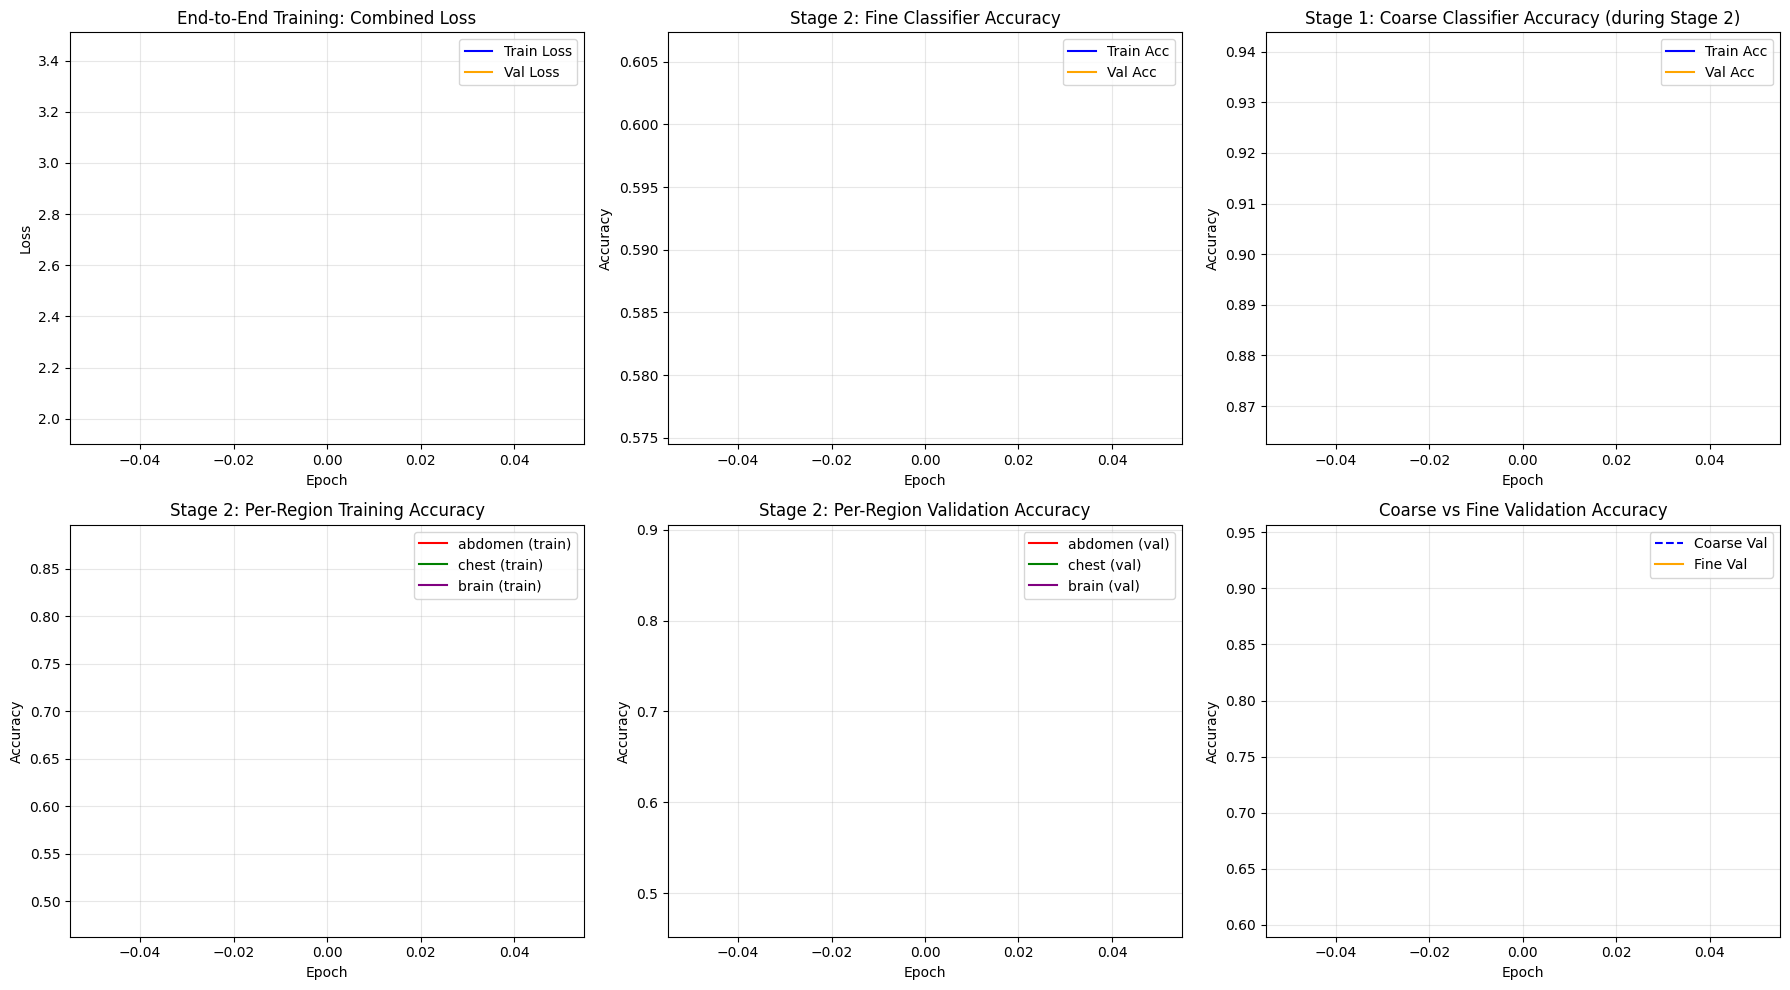

In [10]:
# Plot training history
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Overall Loss
axes[0, 0].plot(history['train_loss'], label='Train Loss', color='blue')
axes[0, 0].plot(history['val_loss'], label='Val Loss', color='orange')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('End-to-End Training: Combined Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Overall Fine Accuracy
axes[0, 1].plot(history['train_acc'], label='Train Acc', color='blue')
axes[0, 1].plot(history['val_acc'], label='Val Acc', color='orange')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Stage 2: Fine Classifier Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Coarse Accuracy (Now also tracked during Stage 2!)
axes[0, 2].plot(history['coarse_train_acc'], label='Train Acc', color='blue')
axes[0, 2].plot(history['coarse_val_acc'], label='Val Acc', color='orange')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Accuracy')
axes[0, 2].set_title('Stage 1: Coarse Classifier Accuracy (during Stage 2)')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Per-region training accuracy
colors = ['red', 'green', 'purple']
for i, (region_name, accs) in enumerate(history['region_train_acc'].items()):
    axes[1, 0].plot(accs, label=f'{region_name} (train)', color=colors[i % len(colors)])
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_title('Stage 2: Per-Region Training Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Per-region validation accuracy
for i, (region_name, accs) in enumerate(history['region_val_acc'].items()):
    axes[1, 1].plot(accs, label=f'{region_name} (val)', color=colors[i % len(colors)])
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_title('Stage 2: Per-Region Validation Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Combined comparison
axes[1, 2].plot(history['coarse_val_acc'], label='Coarse Val', color='blue', linestyle='--')
axes[1, 2].plot(history['val_acc'], label='Fine Val', color='orange', linestyle='-')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('Accuracy')
axes[1, 2].set_title('Coarse vs Fine Validation Accuracy')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{PATHS['figures']}/stage2_fine_training_{MODEL_CONFIG['architecture']}.png", dpi=150)
plt.show()

## 6. Full Hierarchical Evaluation on Test Set

In [11]:
def evaluate_hierarchical_model_end_to_end(model, test_loader, device, dataset_info):
    """Evaluate hierarchical model end-to-end with true routing logic."""
    model.eval()
    
    # Reconstruct region offsets for global label mapping
    region_offsets = {}
    current_offset = 0
    sorted_regions = ['abdomen', 'chest', 'brain'] # Fixed order
    for region in sorted_regions:
        region_offsets[region] = current_offset
        current_offset += dataset_info['region_num_classes'][region]
    
    all_preds_global = []
    all_labels_global = []
    
    # For consistency metrics
    coarse_preds_all = []
    coarse_labels_all = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="End-to-End Evaluation"):
            if len(batch) == 4:
                imgs, coarse_labels, fine_labels, global_labels_true = batch
            else:
                raise ValueError("DataLoader must return global labels for end-to-end evaluation!")
                
            imgs = imgs.to(device, dtype=torch.float32)
            if imgs.max() > 1:
                imgs = imgs / 255.0
            
            # 1. Predict Coarse Region
            coarse_logits = model.forward_coarse(imgs)
            coarse_preds = coarse_logits.argmax(1)
            
            # Store coarse metrics
            coarse_preds_all.extend(coarse_preds.cpu().numpy())
            coarse_labels_all.extend(coarse_labels.numpy())
            all_labels_global.extend(global_labels_true.numpy())
            
            # 2. Route to Fine Classifiers (based on PREDICTION)
            batch_preds_global = []
            
            # We must process sample-by-sample or group by predicted region for efficiency
            # Grouping by predicted region is more efficient for batch processing
            for region_idx, region_name in dataset_info['idx_to_region'].items():
                # Find all samples predicted as this region
                mask = (coarse_preds == region_idx)
                if not mask.any():
                    continue
                
                # Extract these samples
                region_imgs = imgs[mask]
                
                # Predict fine labels
                fine_logits = model.forward_fine(region_imgs, region_name)
                fine_preds_local = fine_logits.argmax(1)
                
                # Map to global index: offset + local_idx
                offset = region_offsets[region_name]
                fine_preds_global = fine_preds_local + offset
                
                # We need to place these back in the correct order
                # Current naive approach: iterate row by row is safer for ordering
                pass
            
            # Row-by-row fallback for absolute correctness of order
            for i in range(len(imgs)):
                pred_r_idx = coarse_preds[i].item()
                pred_r_name = dataset_info['idx_to_region'][pred_r_idx]
                
                # Forward fine for single image (unsqueeze dim 0)
                img_single = imgs[i:i+1]
                fine_logit = model.forward_fine(img_single, pred_r_name)
                pred_local = fine_logit.argmax(1).item()
                
                pred_global = region_offsets[pred_r_name] + pred_local
                all_preds_global.append(pred_global)
                
    return {
        'y_true': np.array(all_labels_global),
        'y_pred': np.array(all_preds_global),
        'coarse_true': np.array(coarse_labels_all),
        'coarse_pred': np.array(coarse_preds_all)
    }

In [12]:
# Load best model for evaluation
model.load_state_dict(torch.load(f"{PATHS['models']}/hierarchical_model_{MODEL_CONFIG['architecture']}.pth"))

# Evaluate on test set END-TO-END
raw_results = evaluate_hierarchical_model_end_to_end(model, test_loader, DEVICE, dataset_info)

from utils.metrics import compute_comprehensive_metrics

# Compute standardized metrics
metrics = compute_comprehensive_metrics(
    raw_results['y_true'], 
    raw_results['y_pred'], 
    class_names=[dataset_info['global_idx_to_name'][i]['name'] for i in range(len(dataset_info['global_idx_to_name']))]
)

# Calculate hierarchy consistency
coarse_correct = (raw_results['coarse_true'] == raw_results['coarse_pred']).sum()
fine_correct = (raw_results['y_true'] == raw_results['y_pred']).sum()
both_correct = ((raw_results['coarse_true'] == raw_results['coarse_pred']) & (raw_results['y_true'] == raw_results['y_pred'])).sum()
coarse_acc = coarse_correct / len(raw_results['y_true'])

print("\n" + "="*60)
print("FULL HIERARCHICAL END-TO-END TEST RESULTS")
print("="*60)
print(f"Overall Accuracy: {metrics['accuracy']:.4f}")
print(f"Coarse Accuracy:  {coarse_acc:.4f}")
print(f"Consistency (Both Correct): {both_correct / len(raw_results['y_true']):.4f}")
print("\nDetailed Metrics:")
print(f"Precision (Weighted): {metrics['precision_weighted']:.4f}")
print(f"Recall (Weighted):    {metrics['recall_weighted']:.4f}")
print(f"F1-Score (Weighted):  {metrics['f1_weighted']:.4f}")


C:\Users\BS-06\AppData\Local\Temp\ipykernel_9764\3199912835.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{PATHS['models']}/hierarch

ValueError: DataLoader must return global labels for end-to-end evaluation!

## 7. Save Final Model Information

In [ ]:
# %% CELL
# Plot Confusion Matrix (End-to-End)
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(12, 10))
cm = confusion_matrix(raw_results['y_true'], raw_results['y_pred'])
class_names = [dataset_info['global_idx_to_name'][i]['name'] for i in range(len(dataset_info['global_idx_to_name']))]

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'End-to-End Confusion Matrix - {MODEL_CONFIG["architecture"]} (Hierarchical)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

cm_path = f"{PATHS['models']}/hierarchical_confusion_matrix_{MODEL_CONFIG['architecture']}.png"
plt.savefig(cm_path, dpi=150)
print(f"Confusion Matrix saved to: {cm_path}")
plt.show()

In [ ]:
# Save final model info with standardized metrics
from utils.metrics import save_metrics_json

# Prepare comprehensive info dict
final_info = {
    'model_path': f"{PATHS['models']}/hierarchical_model_{MODEL_CONFIG['architecture']}.pth",
    'architecture': MODEL_CONFIG['architecture'],
    'training_mode': 'end-to-end',
    'metrics': metrics,
    'hierarchical_metrics': {
        'coarse_accuracy': float(coarse_acc),
        'consistency_both_correct': float(both_correct / len(raw_results['y_true']))
    }
}

output_path = f"{PATHS['models']}/hierarchical_model_info_{MODEL_CONFIG['architecture']}.json"
save_metrics_json(final_info, output_path)

print(f"\nFinal model info saved to: {output_path}")



Final model info saved to: /home/luca/HierarchicalMIC/models/hierarchical_model_info_enhanced.json

Hierarchical end-to-end training complete! You can now use the model for inference.
